# Packages Installs, imports, and presets

In [158]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model, MobileViTV2Config
import torch
import torchmetrics
from torch import optim
import lightning as L
import torch
import torch.nn as nn

In [159]:
from lightning.pytorch.loggers import WandbLogger
import wandb
wandb.init() 

epoch,▁▁▃▃▆▆██
train_loss,▁▂▇█
trainer/global_step,▁▁▁▁▃▃▃▃▆▆▆▆██
val_loss,▁███
validation_accuracy,█▁▁▁
validation_accuracy_macro,█▁▁▁
epoch,3
train_loss,2.36951
trainer/global_step,723
val_loss,2.48495
validation_accuracy,0.05809


In [160]:
INPUT_SIZE = (256,256,3)

## Removing missing features

In [161]:
df_train= pd.read_parquet('data/iec104_train.parquet')
df_validation = pd.read_parquet('data/iec104_validation.parquet')
df_test=pd.read_parquet('data/iec104_test.parquet')

In [162]:
missing_features=[c for c,v in ((df_train==-1).sum() == len(df_train)).items() if v==True]

In [163]:
df_train=df_train.drop(missing_features,axis=1)
df_test=df_test.drop(missing_features,axis=1)
df_validation=df_validation.drop(missing_features,axis=1)

In [164]:
df_train.shape

(337874, 1123)

In [165]:
len(set(df_train.index))

8673

In [166]:
display(df_train['label'].value_counts())
display(df_validation['label'].value_counts())
display(df_test['label'].value_counts())

label
1     262291
3      12991
7      12833
6      10520
4       7317
0       6986
5       6963
10      5836
8       4608
2       3919
9       3610
Name: count, dtype: int64

label
1     27171
3      3262
7      3203
6      2565
0      1859
4      1801
5      1646
10     1444
9      1187
2      1183
8      1068
Name: count, dtype: int64

label
1     143436
3       4086
7       3872
6       3074
4       2353
0       2208
5       2148
10      1830
8       1421
9       1173
2       1116
Name: count, dtype: int64

In [167]:
# # del df_train_initial
# del df

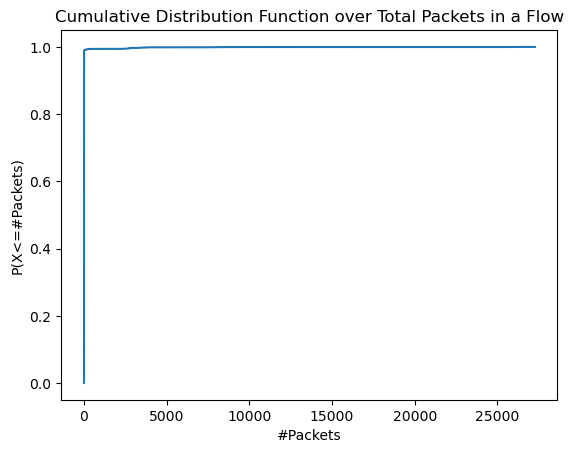

In [168]:
# df_test.groupby('flow').

def plot_cdf(x):
  plt.title('Cumulative Distribution Function over Total Packets in a Flow')
  plt.xlabel("#Packets")
  plt.ylabel(r"P(X<=#Packets)")
  # print(x)
  plt.plot(x)
tmp=df_train.groupby('flow')['tv_sec'].count().value_counts()
tmp=tmp.sort_index().cumsum()
tmp = tmp/tmp.max()
plot_cdf(tmp)

In [169]:
tmp=df_train.groupby('flow')['tv_sec'].count().value_counts()
tmp=tmp.sort_index().cumsum()
# tmp = tmp/tmp.max()
tmp

tv_sec
2           7
3           8
4          10
5          11
6          44
         ... 
8562     8669
9579     8670
25537    8671
26601    8672
27265    8673
Name: count, Length: 100, dtype: int64

In [170]:
# TRAIN_SIZE = 0.7
# tmp = random.shuffle(list(set(df_train.index)))
# TRAIN_SAMPLES = int(len(df_train)*TRAIN_SIZE)
# df_train,df_validation = df_train.iloc[:TRAIN_SAMPLES],df_train.iloc[TRAIN_SAMPLES:]

In [171]:
assert df_train.groupby(df_train.index)['label'].nunique().max()==1

In [172]:
df_train

,tv_sec,tv_usec,ipv4_ver_0,ipv4_ver_1,ipv4_ver_2,ipv4_ver_3,ipv4_hl_0,ipv4_hl_1,ipv4_hl_2,ipv4_hl_3,...,payload_bit_695,payload_bit_696,payload_bit_697,payload_bit_698,payload_bit_699,payload_bit_700,payload_bit_701,payload_bit_702,payload_bit_703,label
flow,,,,,,,,,,,,,,,,,,,,,
1_192.168.1.28_192.168.1.24_38333_2404_TCP_c_rd_na_1_DoS_c_rd_na_1_DoS,1591381875,252954,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
1_192.168.1.28_192.168.1.24_38333_2404_TCP_c_rd_na_1_DoS_c_rd_na_1_DoS,1591381875,261514,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
1_192.168.1.28_192.168.1.24_38333_2404_TCP_c_rd_na_1_DoS_c_rd_na_1_DoS,1591381882,232355,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
1_192.168.1.28_192.168.1.24_38333_2404_TCP_c_rd_na_1_DoS_c_rd_na_1_DoS,1591381892,245072,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
1_192.168.1.28_192.168.1.24_38333_2404_TCP_c_rd_na_1_DoS_c_rd_na_1_DoS,1591381892,248959,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_192.168.1.27_192.168.1.25_34739_2404_TCP_c_rd_na_1_DoS_c_rd_na_1_DoS,1591374597,681502,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
1_192.168.1.27_192.168.1.25_34739_2404_TCP_c_rd_na_1_DoS_c_rd_na_1_DoS,1591374607,689628,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3
1_192.168.1.27_192.168.1.25_34739_2404_TCP_c_rd_na_1_DoS_c_rd_na_1_DoS,1591374607,693325,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,3


#### Static vs Dynamic Packet (w.r.t. Flow) Features

In [173]:
# pat = '([\w\d_]+)_?\d*'
# pat=r"([\w_]+)_\d*"
pat=r"([\w_]+)_\d+"
tmp=df_train.iloc[:1000, df_train.columns != 'label'].T.reset_index().replace(to_replace=pat, value=r"\1", regex=True).groupby('index').agg(lambda x: ''.join(map(str,x))).T
tmp = tmp.groupby(tmp.index).nunique().max().to_frame().sort_values(by=0,ascending=False)

In [174]:
static_features= set(tmp.loc[tmp[0]==1].index)
dynamic_features = set(tmp.index) - static_features

In [175]:
dynamic_features_raw = {'tcp_opt','tv_sec','tv_usec','tcp_cksum','tcp_ackn','tcp_seq','ipv4_tl'}
dynamic_features_reduce =  dynamic_features - dynamic_features_raw

In [176]:
dynamic_features_raw,dynamic_features_reduce,static_features = list(dynamic_features_raw),list(dynamic_features_reduce),list(static_features)
dynamic_features=  list(dynamic_features)

In [177]:
# [i for i in df_train.columns if len([for i in dynamic_features]) > 0]
def get_bit_columns(features):
  dynamic_features_bit_columns= []
  for column_name in df_train.columns:
    for feature_name in features:
      if  feature_name in column_name:
        dynamic_features_bit_columns.append(column_name)
        break
  return dynamic_features_bit_columns

In [178]:
dynamic_features_bit_columns= get_bit_columns(dynamic_features)
static_features_bit_columns= get_bit_columns(static_features)

In [179]:
dynamic_features

['tv_sec',
 'ipv4_id',
 'tcp_sprt',
 'ipv4_ttl',
 'tcp_opt',
 'tcp_dprt',
 'tcp_wsize',
 'ipv4_src',
 'ipv4_cksum',
 'ipv4_tl',
 'tcp_seq',
 'ipv4_dst',
 'tcp_ackn',
 'tcp_cksum',
 'tv_usec',
 'payload_bit']

In [180]:
num_dynamic_features = len(dynamic_features_bit_columns)
num_static_features= len(static_features_bit_columns)
num_dynamic_features, num_static_features

(1050, 72)

In [181]:
len(set(df_train.index))

8673

## Training Dataset


In [194]:
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.utils.data import Dataset

BATCH_SIZE=48

class IEC104Dataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.flow_int_id = list(set(self.df.index))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.flow_int_id)

    def __getitem__(self, idx):
        df_idx = self.flow_int_id[idx]
        flow = self.df.loc[df_idx, self.df.columns != 'label']
        label = self.df.loc[df_idx, 'label']

        if isinstance(flow, pd.Series):
            flow = flow.to_frame().T

        if not isinstance(label, np.int64):
            label = label.iloc[0]
        label = torch.tensor(label)

        if self.transform:
            flow = self.transform(flow)
        if self.target_transform:
            label = self.target_transform(label)

        return flow, label

def feature_transform(flow):
    # start_time = time.time()
    # Convert flow to a DataFrame if it's not already
    flow = pd.DataFrame(flow)

    # Extract dynamic and static features
    dynamic_features = flow.loc[:, dynamic_features_bit_columns].values
    static_features = flow.loc[:, static_features_bit_columns].iloc[0].values
    
    # Convert to tensors
    dynamic_tensor = torch.tensor(dynamic_features, dtype=torch.float32)
    static_tensor = torch.tensor(static_features, dtype=torch.float32)

    # Determine the shape of the dynamic tensor
    

    # Preallocate tensor for X with -1
    # print(INPUT_SIZE)
    total_dynamic_size = INPUT_SIZE[1] * INPUT_SIZE[2]
    
    dynamic_tensor=dynamic_tensor[:,:total_dynamic_size]
    dynamic_shape = dynamic_tensor.shape
    
    X = -torch.ones(INPUT_SIZE[0], total_dynamic_size, dtype=torch.float32)

    # Fill in the dynamic features (ensure no size mismatch)
    min_shape_0 = min(dynamic_shape[0], INPUT_SIZE[0])

    X[:min_shape_0, :dynamic_shape[1]] = dynamic_tensor[-min_shape_0:, :dynamic_shape[1]]
    X = X.view(3,256,256)
    X = (X+1)/2
    return [X, static_tensor]
# class_sample_output=df_train[['label']].value_counts().sort_index().tolist()



NUM_WORKERS =16
PREFETCH_FACTOR=2
train_dataset = IEC104Dataset(df_train,transform = feature_transform)
validation_dataset = IEC104Dataset(df_validation,transform = feature_transform)
test_dataset = IEC104Dataset(df_test,transform = feature_transform)

In [195]:
class_sample_output=df_train.reset_index().groupby('label')['flow'].nunique().tolist()
print(class_sample_output)
sampling_weights = 1 / torch.Tensor(class_sample_output)
print(sampling_weights)

labels = train_dataset.df.groupby('flow')['label'].unique()
labels=[labels.loc[i][0] for i in train_dataset.flow_int_id]
samples_weight = np.array([sampling_weights[t] for t in labels]).flatten()

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
print(samples_weigth)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))


# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,sampler = sampler)
validation_loader = data_utils.DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

[876, 53, 300, 1609, 919, 778, 1156, 1597, 532, 329, 524]
tensor([0.0011, 0.0189, 0.0033, 0.0006, 0.0011, 0.0013, 0.0009, 0.0006, 0.0019,
        0.0030, 0.0019])
tensor([0.0009, 0.0011, 0.0030,  ..., 0.0189, 0.0006, 0.0013],
       dtype=torch.float64)


## Model Design

In [196]:
model_vitv2_output_shape = [ 512, 8, 8]
NUM_CLASSES = df_train.label.nunique()

In [197]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda"
    return device
DEVICE = get_device()

In [198]:
import seaborn as sns

In [199]:
import wandb

In [200]:

class FullyConnectedNet(nn.Module):
    def __init__(self,input_size,output_size,l1=180,l2=128,l3=20,dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(input_size, l1),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(l1, l2),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(l2, l3),
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Linear(l3, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.net(x)
        return x

class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0]).last_hidden_state
        # print("Hidden states shape:", hidden_states.shape)
        # print("Additional input shape:", x[1].shape)
        concatenated_input = torch.cat((torch.flatten(hidden_states, start_dim=1), torch.flatten(x[1], start_dim=1)),dim=1)
        # print("Concatenated input shape:", concatenated_input.shape)
        return self.decoder(concatenated_input)
        # print(hidden_states.shape,x[1].shape)
        # return self.decoder(torch.concat((torch.flatten(hidden_states,start_dim=1), torch.flatten(x[1],start_dim=1))))


class LFVIT(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.step_outputs = []
        self.step_target = []
    def forward(self, inputs):
        return self.model(inputs)
    def training_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        loss = nn.functional.cross_entropy(target_prediction, y)
        # self.step_outputs.append(target_prediction)
        # self.step_target.append(y)
        self.log('train_loss',loss,on_epoch=True,on_step=False)
        return loss
        # metrics = self._shared_eval_step(batch, batch_idx,step_type='train')
        # for key,value in metrics.copy().items():
        #     metrics["train_"+key]=metrics.pop(key)
        # self.log_dict(metrics,prog_bar=True,on_step=False, on_epoch=True)
        # return metrics['train_loss']
    def validation_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        self.step_outputs.append(target_prediction)
        self.step_target.append(y)
        loss = nn.functional.cross_entropy(target_prediction, y)
        self.log('val_loss',loss,on_epoch=True,on_step=False)
        # loss = nn.functional.cross_entropy(target_prediction, y)
        # self.log('val_loss',loss)
    def test_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        self.step_outputs.append(target_prediction)
        self.step_target.append(y)        
    # def on_test_epoch_end(self):
    def on_test_epoch_end(self):
        self._shared_on_epoch_end(end_type='test')
    def on_validation_epoch_end(self):
        self._shared_on_epoch_end('validation')
    def _shared_on_epoch_end(self,end_type):
        all_preds = torch.cat(self.step_outputs)
        all_targets = torch.cat(self.step_target)
        # all_preds=torch.flatten(all_preds,start_dim=0,end_dim=1)
        # all_targets=torch.flatten(all_targets,start_dim=0,end_dim=1)
        # print(all_preds[:])
        # print(all_targets.shape)
        # print(all_preds.shape)
        # print(all_targets[:5])
        # print(all_preds[:5])
        metrics = dict()
        suffix= end_type+'_'
        # print(all_preds.shape)
        # print(all_targets.shape)        
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        metrics[suffix+'accuracy'] = accuracy(all_preds, all_targets)
        
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'accuracy_macro'] = accuracy(all_preds, all_targets)

        confusionmatrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix", images=['tmp/confusionmatrix.png'])
        
        confusionmatrix = torchmetrics.ConfusionMatrix(normalize='true',task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix_normalized.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix_normalized", images=['tmp/confusionmatrix_normalized.png'])
        
        self.log_dict(metrics)
        self.step_outputs.clear()
        self.step_target.clear()
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')
        return {'optimizer':optimizer,"lr_scheduler":{"scheduler": scheduler, "interval": "epoch","monitor": "val_loss"}}


In [201]:

# accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)

# accuracy(torch.tensor(4, device='cuda:0'),
# torch.tensor([0.0824, 0.0977, 0.1032, 0.0896, 0.0766, 0.1045, 0.0956, 0.0752, 0.0876,
#         0.0868, 0.1010], device='cuda:0'))

In [202]:
model_vitv2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
# model_vitv2 = MobileViTV2Model(config=MobileViTV2Config())
decoder=FullyConnectedNet(np.prod(model_vitv2_output_shape)+num_static_features,NUM_CLASSES,l1=90,l2=60,l3=40,dropout=0.2)
fvit = FVIT(model_vitv2,decoder)
model_fvit = LFVIT(fvit)

/home/hwerneck/miniconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Running


In [203]:
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('heitor57/lightning_logs/model-cg214ll1:v12', type='model')
# artifact_dir = artifact.download()

In [204]:
# checkpoint = torch.load('artifacts/model-cg214ll1:v12/model.ckpt')
# model_fvit.load_state_dict(checkpoint['state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer'])

In [206]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all")

MAX_EPOCHS=500
# timer =  L.pytorch.calalbacks.Timer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor='train_loss',
        filename='iec104-{epoch:02d}-{loss}',
        save_top_k=1,
        mode='min', 
    )

    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback],accelerator=DEVICE,
                        devices=1,log_every_n_steps=10#,limit_train_batches=1.0,limit_val_batches=1.0#,max_time={"minutes": 60}
                        ,logger=wandb_logger)
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    return checkpoint_callback,trainer
checkpoint_callback,trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params
-------------------------------
0 | model | FVIT | 7.4 M 
-------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.412    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/hwerneck/miniconda3/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 11 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


Training: |                                                                                                   …

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

ValueError: path must be a valid string

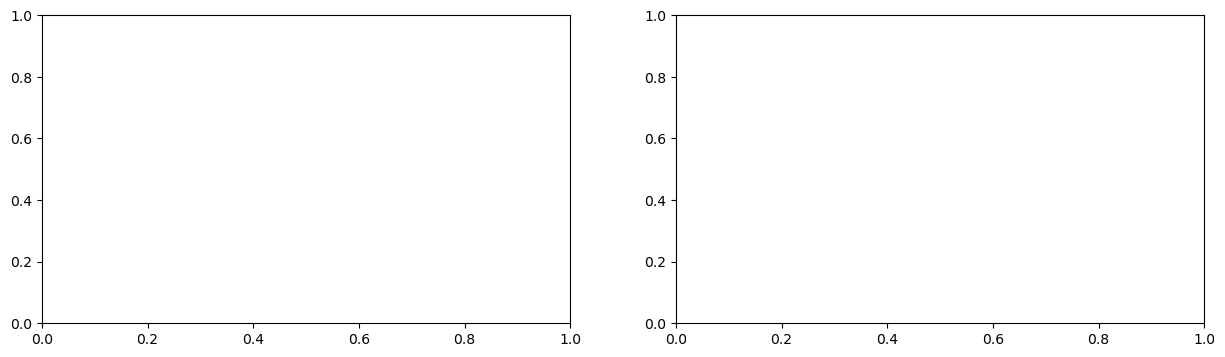

In [ ]:
def plot_training_metrics(trainer,metrics,ax):
    event_acc = EventAccumulator(trainer.logger.log_dir)
    event_acc.Reload()
    for i in range(len(metrics)):
        y=[i.value for i in event_acc.Scalars(metrics[i]['name'])]
        x=np.arange(len(y))+1
        ax[i].plot(x,y,marker='.')
        ax[i].set_xlabel("Epoch")
        ax[i].set_ylabel(metrics[i]['label'])
metrics=[{'name':'train_loss','label':'Training MSE Loss'},{'name':'val_loss','label':'Validation MSE Loss'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

In [ ]:
metrics=[{'name':'train_accuracy','label':'Training Accuracy'},{'name':'val_accuracy','label':'Validation Accuracy'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

In [ ]:
# class ImageFCN(nn.Module):
#     def __init__(self,fcn):
#         super(FVIT, self).__init__()
#         self.fcn = fcn

#     def forward(self, x):
#         return self.fcn(torch.flatten(x))
# ImageFCN(FullyConnectedNet())

In [ ]:
# MAX_EPOCHS=50
# # timer =  L.pytorch.calalbacks.Timer()
# def run_fvit_trainer_fit(train_loader,validation_loader,model):
#     checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
#         monitor='train_loss',
#         filename='iec104-{epoch:02d}-{loss:.2f}',
#         save_top_k=3,
#         mode='min',
#     )

#     early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
#     # cpb=CustomProgressBar()
#     trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback,early_stop_callback],accelerator=DEVICE,
#                         devices=1,log_every_n_steps=10,limit_train_batches=0.1,limit_val_batches=0.1,max_time={"minutes": 5})
#     trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
#     return checkpoint_callback,trainer
# checkpoint_callback,trainer=run_fvit_trainer_fit(
#     train_loader,
#     validation_loader,
#      model=model_fvit)

In [ ]:
class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0]).last_hidden_state
        # print("Hidden states shape:", hidden_states.shape)
        # print("Additional input shape:", x[1].shape)
        # print("Concatenated input shape:", concatenated_input.shape)
        return self.decoder(hidden_states)
decoder= nn.Sequential(nn.Flatten(),
                       nn.Linear(512*8*8, NUM_CLASSES),
                         nn.Softmax(dim=1)
                   )
# model_fvit=FVIT(model_vitv2,decoder)

In [ ]:
fvit = FVIT(model_vitv2,decoder)
model_fvit = LFVIT(fvit)

In [ ]:
MAX_EPOCHS=50
# timer =  L.pytorch.calalbacks.Timer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor='train_loss',
        filename='iec104-{epoch:02d}-{loss}',
        save_top_k=3,
        mode='min',
    )

    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback],accelerator=DEVICE,
                        devices=1,log_every_n_steps=10,limit_train_batches=0.1,limit_val_batches=0.1,max_time={"minutes": 5})
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    return checkpoint_callback,trainer
checkpoint_callback,trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

In [ ]:
# class FVIT(nn.Module):
#     def __init__(self,encoder,decoder):
#         super(FVIT, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, x):
#         hidden_states=self.encoder(x[0]).last_hidden_state
#         # print("Hidden states shape:", hidden_states.shape)
#         # print("Additional input shape:", x[1].shape)
#         # print("Concatenated input shape:", concatenated_input.shape)
#         return self.decoder(hidden_states)
decoder= nn.Sequential(nn.Flatten(),
                       nn.Linear(512*8*8, 100),            nn.ReLU(),
                         
            nn.Linear(100, 50),
nn.Softmax(dim=1),
                   )
# model_fvit=FVIT(model_vitv2,decoder)